# Activations & Gradients, BatchNorm

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
import requests 
url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res = requests.get(url)
words = (res.text).splitlines()
print(len(words), max(len(w) for w in words),min(len(w) for w in words))

32033 15 2


In [6]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}        # map int to char
vocab_size = len(itos)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor(-0.0030) tensor(1.0035)
tensor(-0.0009) tensor(1.0142)


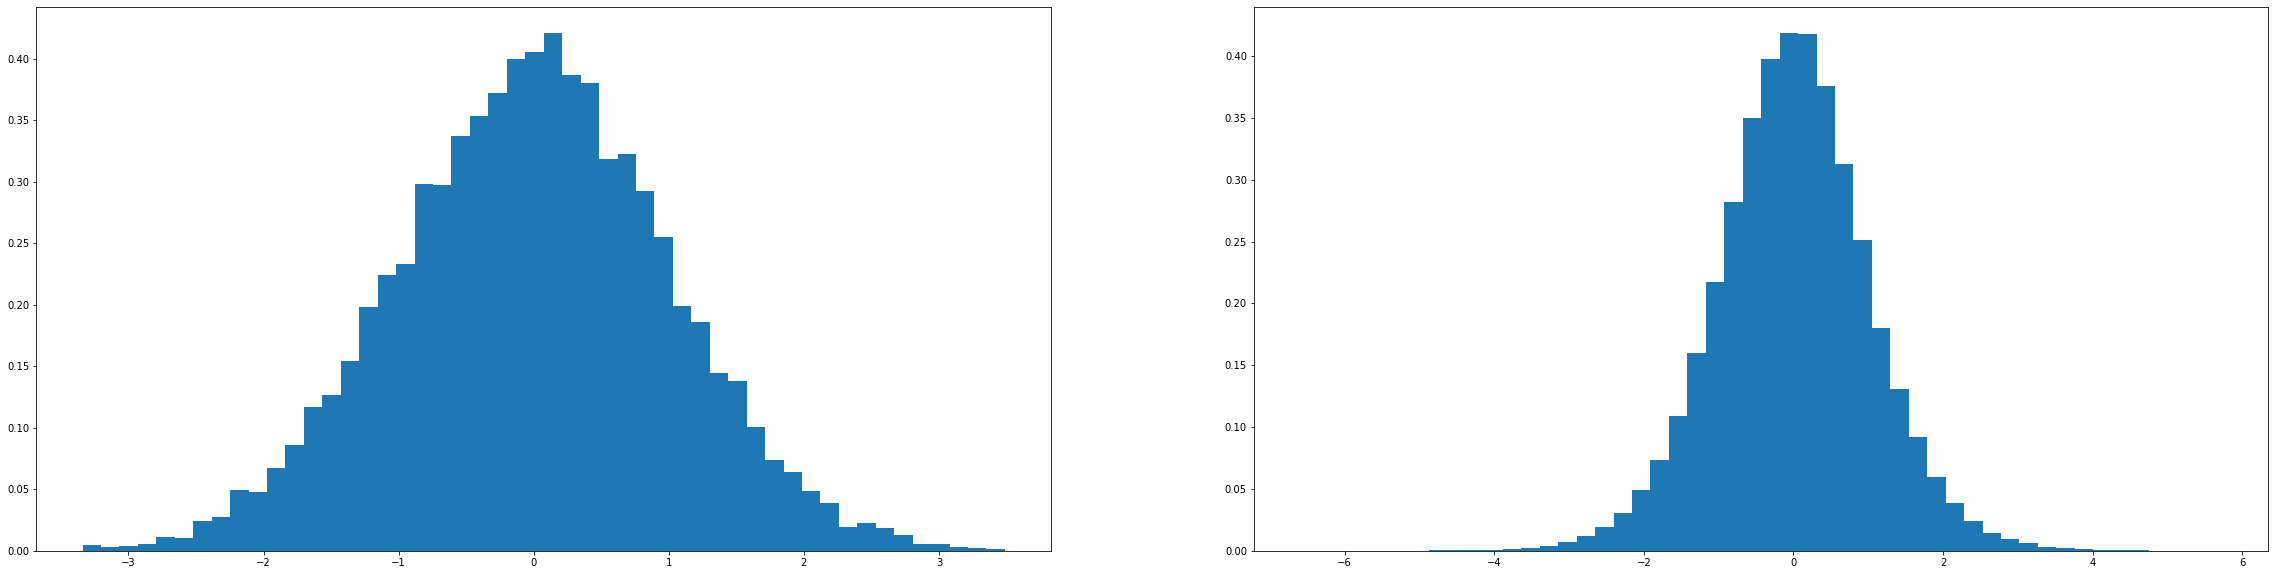

In [8]:
#Kaiming Init https://arxiv.org/pdf/1502.01852.pdf
x = torch.randn(1000, 10)
w = torch.randn(10, 200) /10**0.5 # square root of the fan in to preserve the standnard deviaition
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

tensor(-0.0016) tensor(0.9983)
tensor(0.5617) tensor(0.8236)


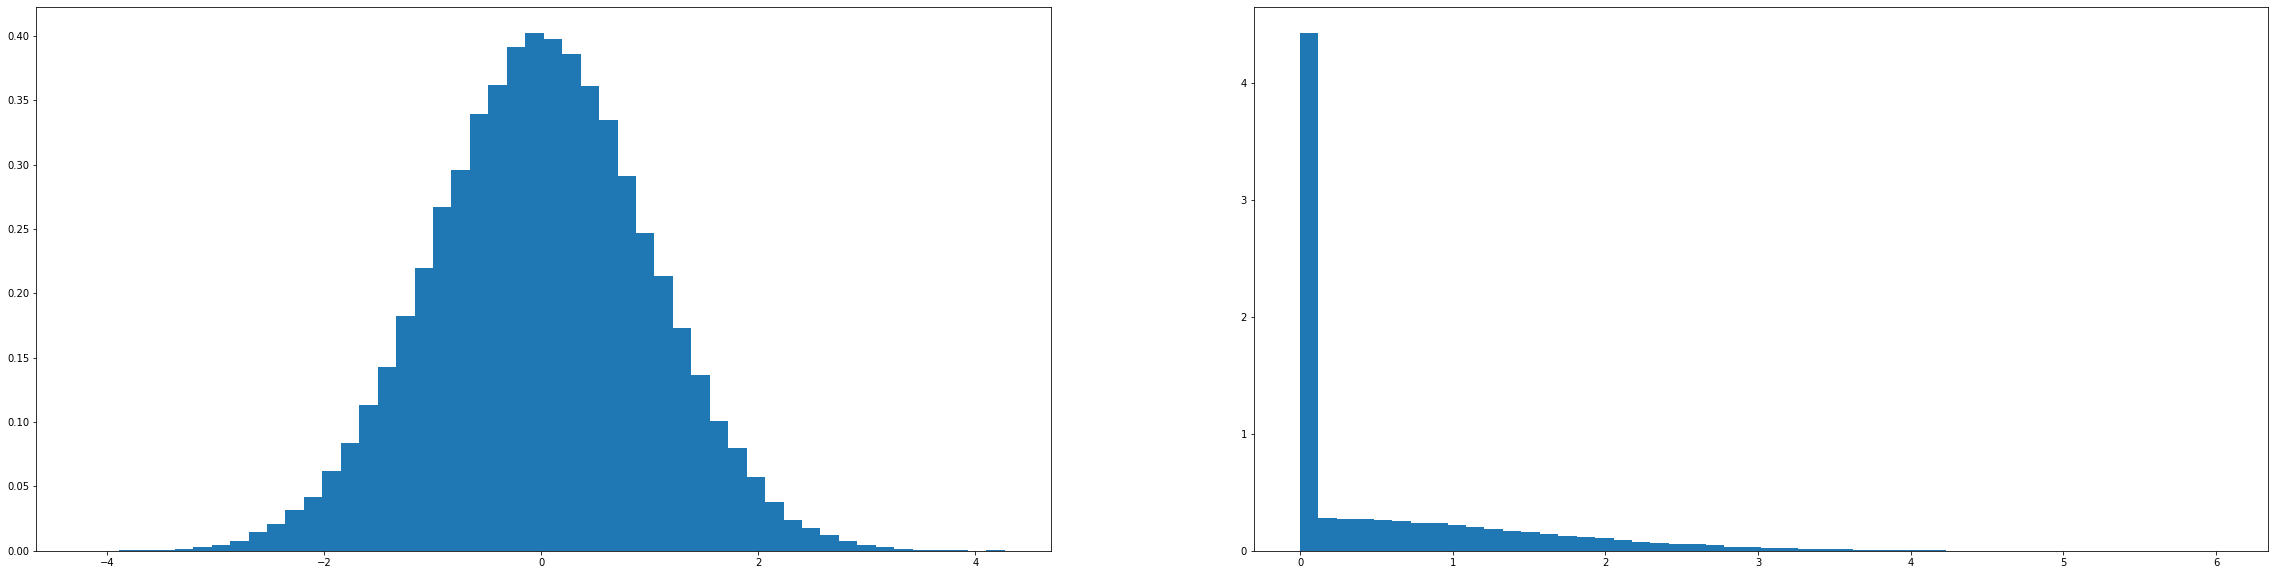

In [7]:
x=torch.randn(1000,100)
y=torch.relu(x)*(2**0.5)
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

tensor(-0.0024) tensor(1.0022)
tensor(-0.0028) tensor(1.0484)


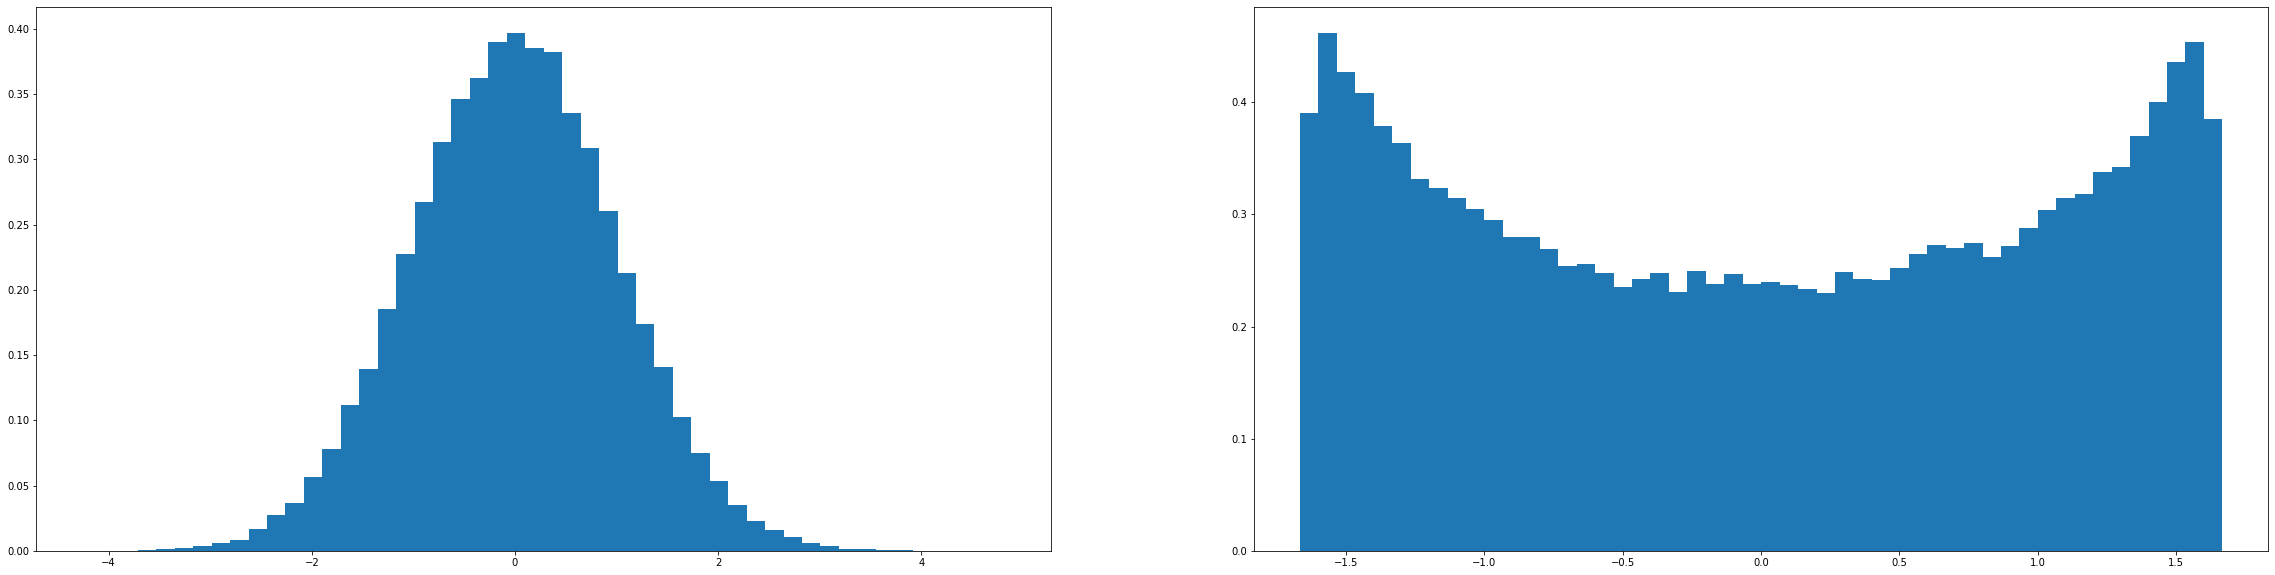

In [8]:
x=torch.randn(1000,100)
y=torch.tanh(x)*(5/3)
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

In [12]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C =  torch.randn((27, n_embd),                  generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)*((5/3)/((n_embd*block_size)**0.5)) #kaiming init
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnstd_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))


parameters = [C, W1 , W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

lri = []
lossi = []
stepi = []

In [14]:
max_steps=2000
n_samples=32

lossi=[]
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (n_samples,))
  
  # forward pass
  emb = C[Xtr[ix]]           #embed charchters in to vectors
  embcat = emb.view(-1, 30)    #convert 3*10 to n_sammples*30
  
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(dim=0, keepdim=True) 
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact =( hpreact - bnmeani)/ bnstdi #subtract the mean & divide by the standard deviation 
  hpreact = hpreact * bngain +bnbias

  with torch.no_grad():
    bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
    bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

  h = torch.tanh(hpreact) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  

      0/   2000: 2.7315
   1000/   2000: 2.2428


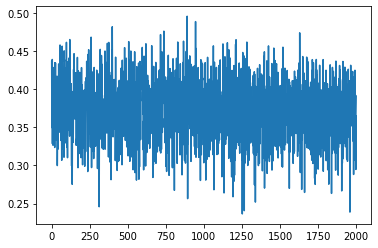

In [15]:
plt.plot(lossi)

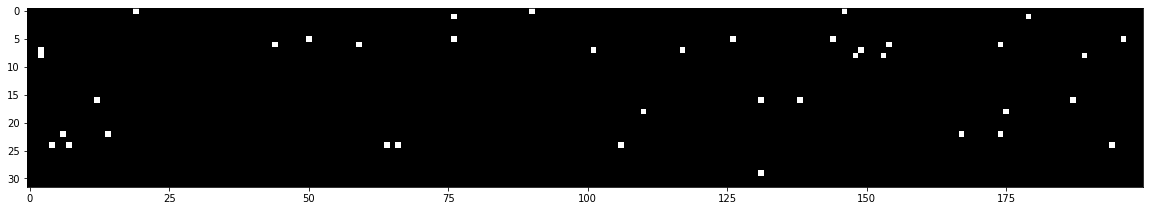

In [16]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation='nearest')

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.3115158081054688
val 2.3100759983062744


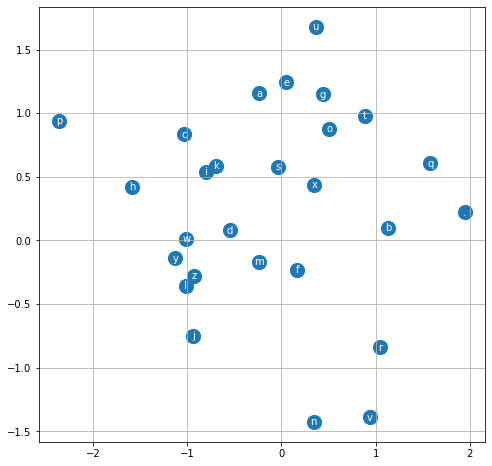

In [18]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize = (8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 # + b1
        #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
          break
    
    print(''.join(itos[i] for i in out))

carpahfato.
hari.
kimrix.
taty.
salassie.
mahnen.
dherahtinaqhi.
nerenia.
chaiiv.
kaleig.


In [21]:
#pytorchifying the code 

In [32]:
class Linear:
    def __init__(self, fan_in, fan_out , bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.bias = torch.zeros((1, fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.5):
        self.eps = eps
        self.momentum = momentum 
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):

        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

        
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3
    # if isinstance(layer, Tanh):
    #   layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



47024


In [39]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 100:
    pass # AFTER_DEBUG: would take out obviously to run full optimization



      0/  20000: 2.4204
   1000/  20000: 2.3576
   2000/  20000: 2.0859
   3000/  20000: 2.5037
   4000/  20000: 2.4346
   5000/  20000: 2.4388
   6000/  20000: 2.0866
   7000/  20000: 2.6178
   8000/  20000: 2.0356
   9000/  20000: 2.1814
  10000/  20000: 2.1810
  11000/  20000: 2.1164
  12000/  20000: 2.0550
  13000/  20000: 2.4968
  14000/  20000: 2.4294
  15000/  20000: 2.6265
  16000/  20000: 2.2405
  17000/  20000: 2.2746
  18000/  20000: 2.1073
  19000/  20000: 2.0182


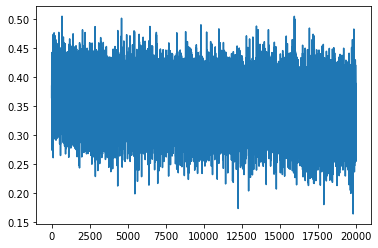

In [40]:
plt.plot(lossi)

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.94%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.69%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.66%


Text(0.5, 1.0, 'activation distribution')

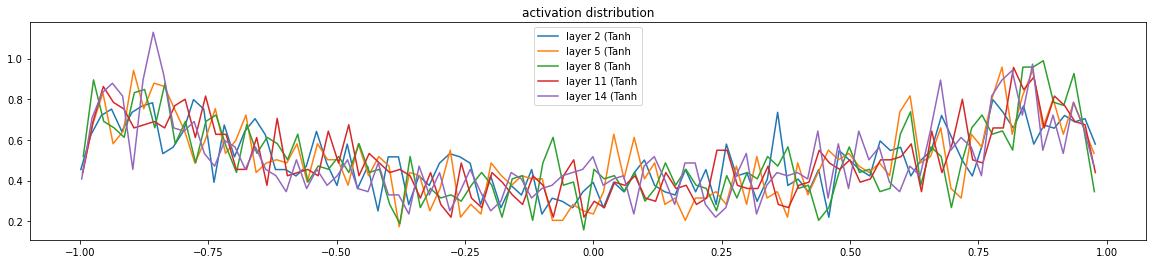

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.000000, std 1.546059e-03
layer 5 (      Tanh): mean +0.000000, std 1.283855e-03
layer 8 (      Tanh): mean -0.000000, std 1.234201e-03
layer 11 (      Tanh): mean +0.000000, std 1.082129e-03
layer 14 (      Tanh): mean +0.000000, std 1.002501e-03


Text(0.5, 1.0, 'gradient distribution')

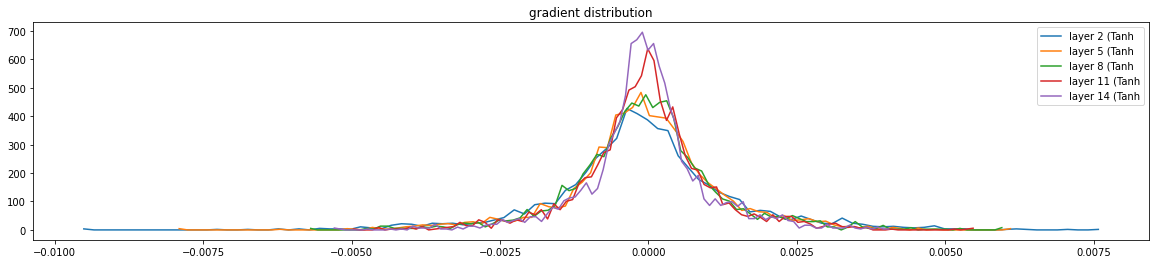

In [35]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000000 | std 3.878810e-03 | grad:data ratio 3.875984e-03
weight  (30, 100) | mean -0.000059 | std 3.843694e-03 | grad:data ratio 1.232445e-02
weight (100, 100) | mean -0.000027 | std 3.413016e-03 | grad:data ratio 2.054210e-02
weight (100, 100) | mean -0.000006 | std 2.879491e-03 | grad:data ratio 1.714971e-02
weight (100, 100) | mean +0.000040 | std 2.694696e-03 | grad:data ratio 1.611681e-02
weight (100, 100) | mean -0.000037 | std 2.490607e-03 | grad:data ratio 1.488211e-02
weight  (100, 27) | mean -0.000031 | std 4.202208e-03 | grad:data ratio 2.549605e-02


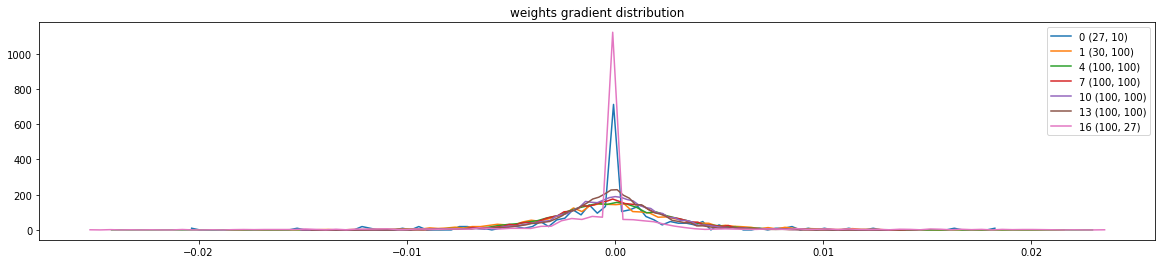

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

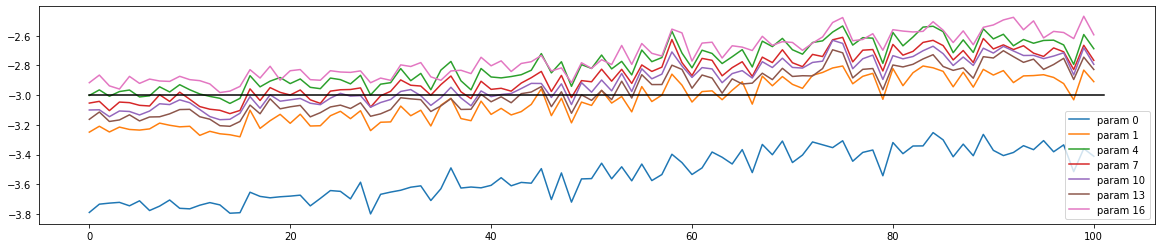

In [37]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
